In [21]:
# Standard library imports
import os
import warnings

# Third-party imports for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Scikit-learn imports for machine learning
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Ensemble models from third-party libraries
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# still to be organized


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
# Load the dataset from a CSV file
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

# Display the shape of the DataFrame (number of rows and columns)
print(df.shape, '\n')

# Print detailed information about the DataFrame, including data types and missing values
print(df.info())  # Provides analysis of NaN values and column types

# Display the first few rows of the DataFrame to preview the data
df.head()

(1190, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB
None


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [23]:
# Display summary statistics for the numerical columns in the DataFrame
df.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [24]:
def duplicate_analysis(df, num_pairs=None):
    """
    Analyzes duplicates in the DataFrame and optionally prints a specified number of duplicate pairs.
    
    Parameters:
        df (DataFrame): The DataFrame to analyze for duplicates.
        num_pairs (int, optional): The number of duplicate pairs to print. If None, prints all pairs.
    """
    # Step 1: Identify and count all duplicates
    duplicates_count = df.duplicated().sum()  # Count duplicates in the DataFrame
    print(f"Number of Duplicates: {duplicates_count}\n")

    # If no duplicates found, exit the function
    if duplicates_count == 0:
        return

    # Step 2: Extract all duplicate rows and sort by columns
    duplicates = df[df.duplicated(keep=False)]  # Get all duplicated rows
    duplicates_sorted = duplicates.sort_values(by=list(df.columns))  # Sort duplicates

    # Step 3: Group and pair duplicates
    duplicate_pairings = {}
    for index, row in duplicates_sorted.iterrows():
        row_tuple = tuple(row)  # Convert row to tuple for uniqueness
        if row_tuple not in duplicate_pairings:
            # Find all rows matching the current row
            matched_indices = duplicates_sorted[duplicates_sorted == row].dropna().index.tolist()
            duplicate_pairings[row_tuple] = matched_indices

    # Prepare a list of unique pairings
    unique_pairings = []
    seen_indices = set()
    for indices in duplicate_pairings.values():
        for pair in zip(indices[:-1], indices[1:]):  # Create pairs from indices
            if pair not in seen_indices and tuple(reversed(pair)) not in seen_indices:
                unique_pairings.append(pair)
                seen_indices.update(pair)

    # Step 4: Sort pairings by the minimum index in each pair
    unique_pairings.sort(key=lambda x: min(x))  # Sort pairs by lowest index

    # Display the pairings, limited by num_pairs if specified
    print(f"First {num_pairs} duplicate pairings ordered by the lowest index in each pair:")
    for i, pair in enumerate(unique_pairings):
        if num_pairs is not None and i >= num_pairs:
            break
        print(pair)  # Print each pair of duplicate indices

# Call the function to analyze duplicates and print the first 15 pairs
duplicate_analysis(df, num_pairs=15)


Number of Duplicates: 272

First 15 duplicate pairings ordered by the lowest index in each pair:
(90, 163)
(556, 604)
(617, 1042)
(618, 1039)
(619, 1146)
(620, 1139)
(621, 1120)
(622, 938)
(623, 899)
(624, 983)
(625, 1045)
(626, 1008)
(627, 920)
(628, 1058)
(629, 972)


In [26]:
# Load the dataset 'processed_cleveland.csv' into a DataFrame
cledf = pd.read_csv('processed_cleveland.csv')

# Print the shape of the DataFrame to see the number of rows and columns
print(cledf.shape, '\n')

# Print information about the DataFrame, including non-null counts and data types
print(cledf.info())  # Provides information on data types and missing values

# Analyze duplicates in the DataFrame and print up to 15 pairs of duplicate rows
duplicate_analysis(cledf, num_pairs=15)

# Display the first few rows of the DataFrame to inspect the data
cledf.head()

(303, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB
None
Number of Duplicates: 0



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [27]:
def fetch_combined_df_cleaned():
    """
    Load and clean the 'heart_statlog_cleveland_hungary_final.csv' dataset:
    - Remove duplicate rows.
    - Filter out rows with 'ST slope' equal to 0.
    - Reset the index after cleaning.
    
    Returns:
        DataFrame: Cleaned DataFrame.
    """
    # Load the dataset
    df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')
    
    # Remove duplicate rows
    df.drop_duplicates(inplace=True)
    
    # Remove rows where 'ST slope' is 0
    mask = df['ST slope'] == 0
    df = df[~mask]
    
    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)
    return df

def fetch_split_datasets_cleaned(): 
    """
    Load and clean datasets, align column names, and perform combination analysis:
    - Clean 'heart_statlog_cleveland_hungary_final.csv'.
    - Load 'processed_cleveland.csv'.
    - Align column names between datasets.
    - Combine datasets and analyze unique and duplicate rows.
    
    Returns:
        tuple: (cleaned DataFrame from 'heart_statlog_cleveland_hungary_final.csv', 
                cleaned DataFrame from 'processed_cleveland.csv')
    """
    # Clean the first dataset
    df = fetch_combined_df_cleaned()
    
    # Load the second dataset
    cledf = pd.read_csv('processed_cleveland.csv')
    
    # Align column names (excluding target column)
    dfcols = list(df.columns[:-1])  # Exclude target column
    cledfcols = list(cledf.columns[len(dfcols):])
    cledf.columns = dfcols + cledfcols
    
    print('Shapes after preprocessing but before combination analysis')
    print("df:", df.shape)
    print("cledf:", cledf.shape, '\n\n')
    
    # Combine datasets and drop duplicates based on relevant columns
    combined = pd.concat([cledf[dfcols], df[dfcols]])
    unique_df = combined.drop_duplicates(keep=False)
    
    # Extract unique rows from 'df' that are not in 'cledf'
    unique_df = df.merge(unique_df, on=dfcols, how='right', indicator=True)
    unique_df = unique_df[unique_df['_merge'] == 'both'].drop('_merge', axis=1)
    
    # Find and extract duplicates
    combined = pd.concat([unique_df[dfcols], df[dfcols]])
    duplicate_df = combined.drop_duplicates(keep=False)
    duplicate_df = df.merge(duplicate_df, on=dfcols, how='right', indicator=True)
    duplicate_df = duplicate_df[duplicate_df['_merge'] == 'both'].drop('_merge', axis=1)
    
    # Update DataFrames to include only unique and duplicate rows
    df = unique_df.reset_index(drop=True)
    cledf = duplicate_df.reset_index(drop=True)
    
    # Print updated shapes
    print('Updated shapes after combination analysis')
    print("df:", df.shape)
    print("cledf:", cledf.shape)
    
    return df, cledf

# Fetch and clean datasets
df, cledf = fetch_split_datasets_cleaned()


Shapes after preprocessing but before combination analysis
df: (917, 12)
cledf: (303, 14) 


Updated shapes after combination analysis
df: (614, 12)
cledf: (303, 12)


In [28]:
from sklearn.preprocessing import StandardScaler

def scalar_fit(X_test, scaler):
    """
    Scales the test data using the provided scaler.
    
    Parameters:
        X_test (DataFrame): The test data to be scaled.
        scaler (StandardScaler): The scaler fitted on the training data.
    
    Returns:
        DataFrame: Scaled test data with original column names.
    """
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_test_scaled

def normalize_Xtrain(X_train):
    """
    Normalizes the training data and returns the scaled data and scaler.
    
    Parameters:
        X_train (DataFrame): The training data to be normalized.
    
    Returns:
        tuple: (DataFrame of scaled training data, StandardScaler object)
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    return X_train_scaled, scaler

def get_sex_groups(X):
    """
    Converts 'sex' feature into binary groups based on the mean value.
    
    Parameters:
        X (DataFrame): DataFrame containing 'sex' feature.
    
    Returns:
        Series: Gender groups with 'female' and 'male' labels.
    """
    mean = X['sex'].mean()
    groups = X['sex']
    groups = (groups <= mean) * -1 + (groups >= mean) * 1 
    return groups.replace({-1: 'female', 1: 'male'})

def get_class_target_balance(df, feature1, feature2):
    """
    Prints the balance of target classes for two features.
    
    Parameters:
        df (DataFrame): The DataFrame to analyze.
        feature1 (str): The first feature to compare.
        feature2 (str): The second feature to compare.
    """
    print(df[[feature1, feature2]].value_counts())


In [29]:
# Select Dataset

# Load and clean the combined dataset
df = fetch_combined_df_cleaned()

# Display the shape of the selected dataset
print(df.shape)

# Display the first few rows of the dataset
df.head()


(917, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [30]:
# Display descriptive statistics for the DataFrame
df.describe()


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.00000,917.000000
mean,53.495093,0.789531,3.251908,132.377317,198.803708,0.232279,0.604144,136.814613,0.404580,0.888332,1.63795,0.552890
std,9.425601,0.407864,0.931502,18.515114,109.443764,0.422517,0.806161,25.473732,0.491078,1.066749,0.60727,0.497466
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.00000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,173.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.00000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.00000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.00000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.00000,1.000000


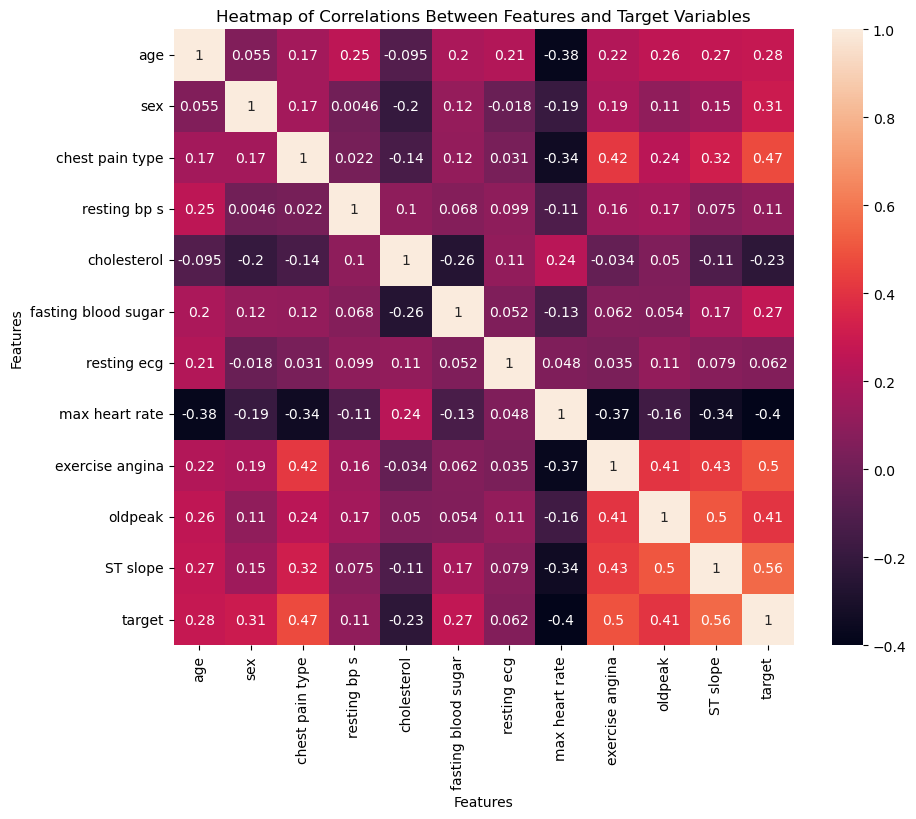

In [49]:
# Heatmap of the correlation matrix of features and target variables
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(df.corr(), annot=True)  # Create the heatmap with annotations
plt.xlabel('Features')  # Label for the x-axis
plt.ylabel('Features')  # Label for the y-axis
plt.title('Heatmap of Correlations Between Features and Target Variables')  # Title of the plot
plt.show()  # Display the plot
#print(df.corr())  # Uncomment to print the correlation matrix


In [32]:
# Separate features and target variable
features = df.drop('target', axis=1)  # Features (X)
target = df['target']  # Target variable (y)

# Normalize features and fit a scaler
X_scaled, scaler = normalize_Xtrain(features)  # Normalize features
X_scaled.columns = features.columns  # Restore original column names to the scaled features
X_scaled.head()  # Display the first few rows of the scaled features


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,-1.432530,0.516309,-1.344701,0.411925,0.824583,-0.550052,-0.749818,1.381996,-0.824310,-0.833201,-1.051095
1,-0.477163,-1.936826,-0.270580,1.492713,-0.171905,-0.550052,-0.749818,0.753555,-0.824310,0.104738,0.596519
2,-1.750986,0.516309,-1.344701,-0.128469,0.769731,-0.550052,0.491306,-1.524543,-0.824310,-0.833201,-1.051095
3,-0.583315,-1.936826,0.803541,0.303846,0.138926,-0.550052,-0.749818,-1.131767,1.213136,0.573708,0.596519
4,0.053597,0.516309,-0.270580,0.952319,-0.034774,-0.550052,-0.749818,-0.581882,-0.824310,-0.833201,-1.051095


In [33]:
print(target.shape)  # Print the shape of the target variable
print(target.head())  # Display the first few rows of the target variable

(917,)
0    0
1    1
2    0
3    1
4    0
Name: target, dtype: int64


   sex  target  count
0    0       0    143
1    0       1     50
2    1       0    267
3    1       1    457


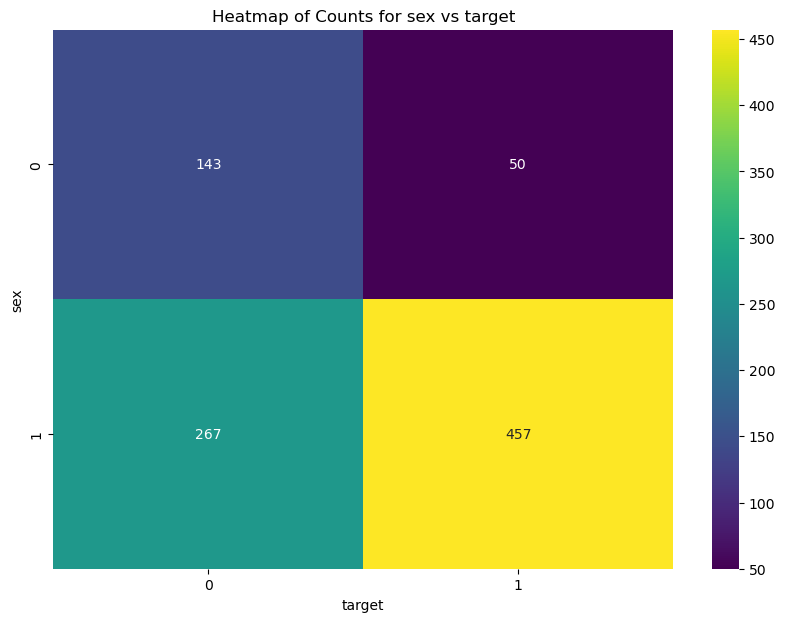

    sex        age  count
0     0    0 to 30      0
1     0   30 to 40     19
2     0   40 to 50     52
3     0   50 to 60     72
4     0   60 to 70     44
5     0   70 to 80      6
6     0  80 to inf      0
7     1    0 to 30      4
8     1   30 to 40     57
9     1   40 to 50    159
10    1   50 to 60    302
11    1   60 to 70    177
12    1   70 to 80     25
13    1  80 to inf      0


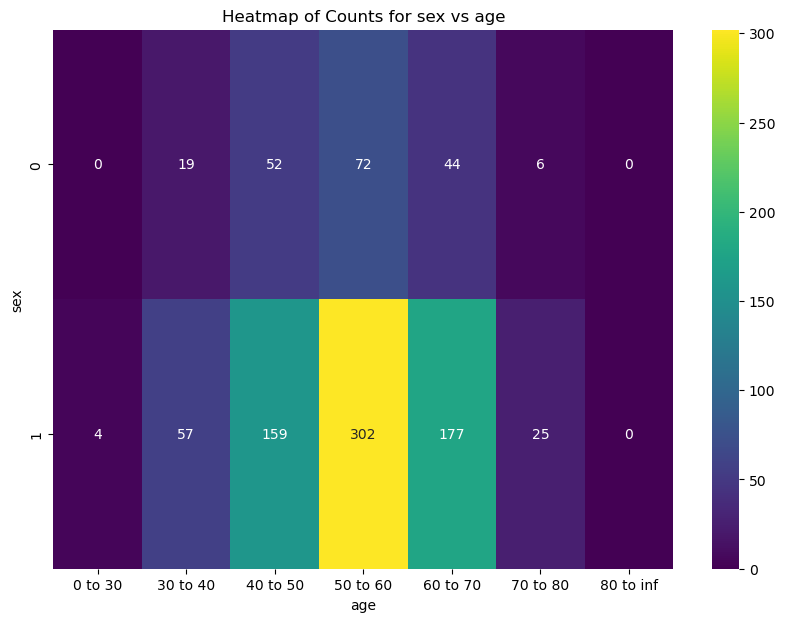

          age  target  count
0     0 to 30       0      4
1     0 to 30       1      0
2    30 to 40       0     50
3    30 to 40       1     26
4    40 to 50       0    126
5    40 to 50       1     85
6    50 to 60       0    162
7    50 to 60       1    212
8    60 to 70       0     59
9    60 to 70       1    162
10   70 to 80       0      9
11   70 to 80       1     22
12  80 to inf       0      0
13  80 to inf       1      0


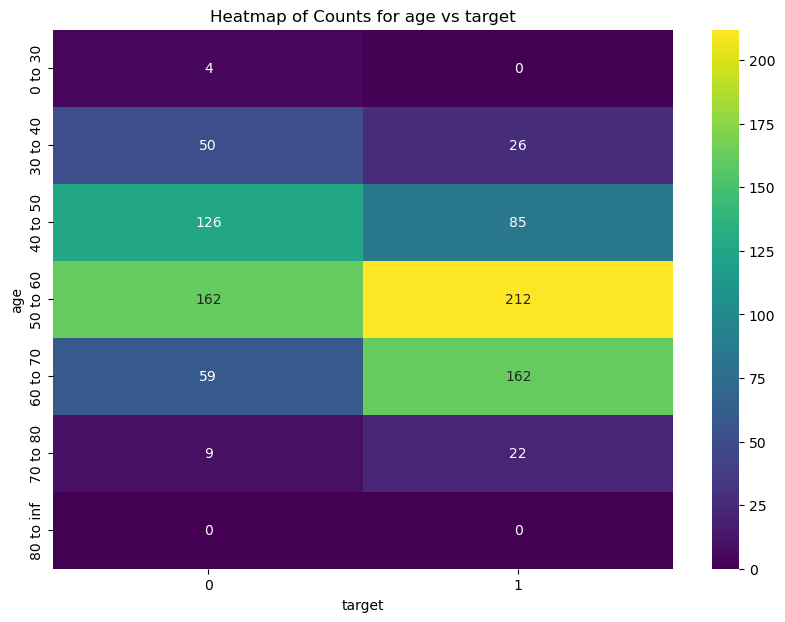

    sex        age  target  count
0     0   18 to 35       0      5
1     0   18 to 35       1      1
2     0   35 to 65       0    123
3     0   35 to 65       1     45
4     0  65 to inf       0     15
5     0  65 to inf       1      4
6     1   18 to 35       0     10
7     1   18 to 35       1      5
8     1   35 to 65       0    241
9     1   35 to 65       1    385
10    1  65 to inf       0     16
11    1  65 to inf       1     67


In [34]:
def display_counts(df, feature_names, bins=None):
    """
    Displays counts for combinations of features, where features can be categorical or binned continuous.
    Plots a heatmap if there are exactly two features.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the features.
    feature_names (list): List of column names to analyze.
    bins (dict): Dictionary with feature names as keys and bin edges as values for continuous features.
    """
    if len(feature_names) < 1:
        print("Please provide at least one feature name.")
        return
    
    # Handle binning if specified
    modified_df = df.copy()
    if bins:
        for feature, edges in bins.items():
            if feature in feature_names:
                modified_df[feature] = pd.cut(
                    modified_df[feature], 
                    bins=edges, 
                    labels=[f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)],
                    include_lowest=True, 
                    right=False
                )
    
    # Create a groupby object based on the provided feature names
    group_data = modified_df.groupby(feature_names, observed=False).size().reset_index(name='count')
    print(group_data)
    
    # Plot a heatmap if there are exactly two features
    if len(feature_names) == 2:
        pivot_table = group_data.pivot_table(
            index=feature_names[0], 
            columns=feature_names[1], 
            values='count', 
            fill_value=0, 
            observed=False
        )
        plt.figure(figsize=(10, 7))
        sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="viridis")
        plt.title(f'Heatmap of Counts for {feature_names[0]} vs {feature_names[1]}')
        plt.ylabel(feature_names[0])
        plt.xlabel(feature_names[1])
        plt.show()

# Example usages:
# Display counts for 'sex' vs 'target'
display_counts(df, ['sex', 'target'])

# Display counts for binned 'age' vs 'sex'
bins = {'age': [0, 30, 40, 50, 60, 70, 80, np.inf]}
display_counts(df, ['sex', 'age'], bins=bins)

# Display counts for binned 'age' vs 'target'
display_counts(df, ['age', 'target'], bins=bins)

# Display counts for binned 'age', 'sex', and 'target'
bins = {'age': [18, 35, 65, np.inf]}
display_counts(df, ['sex', 'age', 'target'], bins=bins)


In [35]:
def make_logistic_regression_classifier():
    """
    Creates and returns a Logistic Regression classifier.
    
    Returns:
        LogisticRegression: A logistic regression model with max_iter set to 1000.
    """
    return LogisticRegression(max_iter=1000)

def make_scalar_logistic():
    """
    Creates and returns a pipeline that includes data scaling and a Logistic Regression classifier.
    
    The pipeline first scales the features using StandardScaler and then applies
    a Logistic Regression classifier with regularization parameter C=0.01 and max_iter set to 1000.
    
    Returns:
        Pipeline: A pipeline with StandardScaler and Logistic Regression classifier.
    """
    return Pipeline([
        ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
        ('classifier', LogisticRegression(C=0.01, max_iter=1000))  # Logistic Regression model
    ])

In [36]:
# Define Logistic Regression classifier
def make_logistic_regression_classifier():
    return LogisticRegression(max_iter=1000)

# Pipeline with Logistic Regression and StandardScaler
def make_scalar_logistic():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=.01, max_iter=1000))
    ])

# Sequential Feature Selection with Logistic Regression
def logistic_sequential_feature_selection(X, y, max_features, num_folds=5, max_iter=5000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    feature_lists = [[]]  # starts with the empty list for 0
    sfs1 = SFS(LogisticRegression(max_iter=max_iter), k_features=max_features, forward=True, scoring='accuracy', cv=num_folds, verbose=2)
    sfs1 = sfs1.fit(X, y)

    previous_features = set()
    # Gather selected features at each step
    for i in range(1, max_features + 1):
        current_features = set(sfs1.subsets_[i]['feature_names'])
        new_feature = current_features - previous_features
        previous_features = current_features.copy()

        feature_lists.append(list(current_features))
        print(f"Step {i}: New Feature Selected: {new_feature}")

    return feature_lists

# Evaluate Feature Selection with Logistic Regression
def evaluate_feature_selection(Xs, names, y, model_types, max_features, num_folds=5, all_features=False, single_split=False, verbose=False):
    def make_model_name(i, make_model):
        """Generate a model name based on index and model function."""
        return f'{i}. {make_model.__name__}'
    
    # Setup cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42) if not single_split else None
    
    # Initialize results dictionary
    results = {make_model_name(i, model_func): {name: {'train_acc': [], 'test_acc': [], 'features': []} 
              for name in names} for (i, model_func) in enumerate(model_types)}
    best_overall_test_acc = 0

    # Iterate through each feature set
    for X, name in zip(Xs, names):
        if all_features:
            max_features = X.shape[1]  # Use all features if all_features is True

        # Perform feature selection
        feature_lists = logistic_sequential_feature_selection(X, y, max_features, num_folds=num_folds)

        # Dummy model for baseline accuracy
        dummy_model = DummyClassifier(strategy='most_frequent')
        if single_split:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            dummy_model.fit(X_train, y_train)
            dummy_accuracy = accuracy_score(y_test, dummy_model.predict(X_test))
        else:
            dummy_accuracy = cross_val_score(dummy_model, X, y, cv=kf, scoring='accuracy').mean()

        # Evaluate models
        for i, make_model in enumerate(model_types):  # Loop through models
            model_name = make_model_name(i, make_model)
            model = make_model()
            if single_split:
                # Train and evaluate model on a single train-test split
                model.fit(X_train, y_train)
                baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
                results[model_name][name]['train_acc'].append(baseline_accuracy)
                results[model_name][name]['test_acc'].append(baseline_accuracy)
            else:
                # Perform cross-validation
                scores = cross_validate(model, X, y, cv=kf, scoring='accuracy', return_train_score=True)
                results[model_name][name]['train_acc'].append(np.mean(scores['train_score']))
                results[model_name][name]['test_acc'].append(np.mean(scores['test_score']))
            results[model_name][name]['features'].append(0)  # Zero indicates baseline (no feature selection)

            # Evaluate models with selected features
            for feat_idx in feature_lists[1:]:  # Skip the first empty list
                model = make_model()
                if single_split:
                    # Select features for training and testing
                    X_train_sfs = X_train.loc[:, feat_idx]
                    X_test_sfs = X_test.loc[:, feat_idx]
                    model.fit(X_train_sfs, y_train)
                    test_accuracy = accuracy_score(y_test, model.predict(X_test_sfs))
                    train_accuracy = accuracy_score(y_train, model.predict(X_train_sfs))
                else:
                    # Use cross-validation with selected features
                    X_sfs = X.loc[:, feat_idx]
                    scores = cross_validate(model, X_sfs, y, cv=kf, scoring='accuracy', return_train_score=True)
                    test_accuracy = np.mean(scores['test_score'])
                    train_accuracy = np.mean(scores['train_score'])
                    if verbose:
                        print(f"Train Scores: {scores['train_score']} \nTest Scores: {scores['test_score']}\n")
                    
                results[model_name][name]['train_acc'].append(train_accuracy)
                results[model_name][name]['test_acc'].append(test_accuracy)
                results[model_name][name]['features'].append(len(feat_idx))
                best_overall_test_acc = max(best_overall_test_acc, test_accuracy)

    return results, best_overall_test_acc, dummy_accuracy

# Plot results for feature selection evaluation
def plot_results(results, best_overall_test_acc=None, dummy_accuracy=None):
    print(f'Best Accuracy: {best_overall_test_acc}')
    for model_name, data_full in results.items():
        plt.figure(figsize=(10, 5))
        for xname, data in data_full.items():
            plt.plot(data['features'][1:], data['train_acc'][1:], marker='o', label=f'{xname} - Train Accuracy')
            plt.plot(data['features'][1:], data['test_acc'][1:], marker='x', label=f'{xname} - Test Accuracy')
            plt.axhline(y=data['test_acc'][0], color='r', linestyle='--', label=f'{xname} - Baseline Accuracy')
        if best_overall_test_acc:
            plt.axhline(y=best_overall_test_acc, color='g', linestyle='-', label='Best Accuracy Any Model')
        if dummy_accuracy:
            plt.axhline(y=dummy_accuracy, color='brown', linestyle='-', label='Dummy Model Accuracy')
        plt.title(f'Model Performance Comparison for {model_name}')
        plt.xlabel('Number of Features Selected')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()


[2024-09-04 02:38:15] Features: 1/11 -- score: 0.8133879781420765
[2024-09-04 02:38:16] Features: 2/11 -- score: 0.8144808743169399
[2024-09-04 02:38:16] Features: 3/11 -- score: 0.8210679496317415
[2024-09-04 02:38:16] Features: 4/11 -- score: 0.8330719885958662
[2024-09-04 02:38:16] Features: 5/11 -- score: 0.8385483487764315
[2024-09-04 02:38:16] Features: 6/11 -- score: 0.8396471846044191
[2024-09-04 02:38:16] Features: 7/11 -- score: 0.8374376336421954
[2024-09-04 02:38:17] Features: 8/11 -- score: 0.8352577809455928
[2024-09-04 02:38:17] Features: 9/11 -- score: 0.8254751722499407
[2024-09-04 02:38:17] Features: 10/11 -- score: 0.821103587550487
[2024-09-04 02:38:17] Features: 11/11 -- score: 0.803688524590164

Step 1: New Feature Selected: {'ST slope'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'exercise angina'}
Step 5: New Feature Selected: {'chest pain type'}
Step 6: New Feature Selected: {'resting ecg'}
Step 7: New Feature Selected: {'fasting blood sugar'}
Step 8: New Feature Selected: {'resting bp s'}
Step 9: New Feature Selected: {'age'}
Step 10: New Feature Selected: {'max heart rate'}
Step 11: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8586956521739131


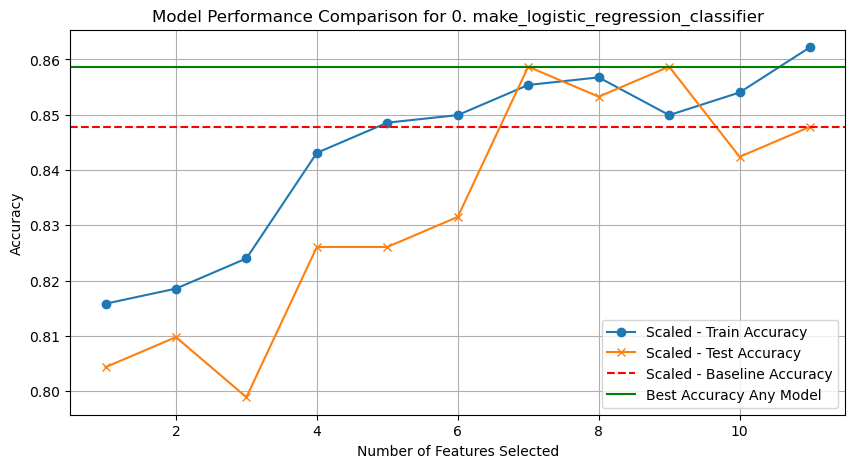

In [37]:
# Lists of data
Xs = [X_scaled]  # Using only scaled features
names = ['Scaled']  # Name corresponding to the scaled features

# List of model functions (logistic regression only, as others are not needed)
model_types = [make_logistic_regression_classifier]

# Maximum number of features to consider
max_features = 11

# Evaluate feature selection
results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(Xs, names, target, model_types, max_features, single_split=True)

# Plot the results
plot_results(results, best_overall_test_acc=best_overall_test_acc)


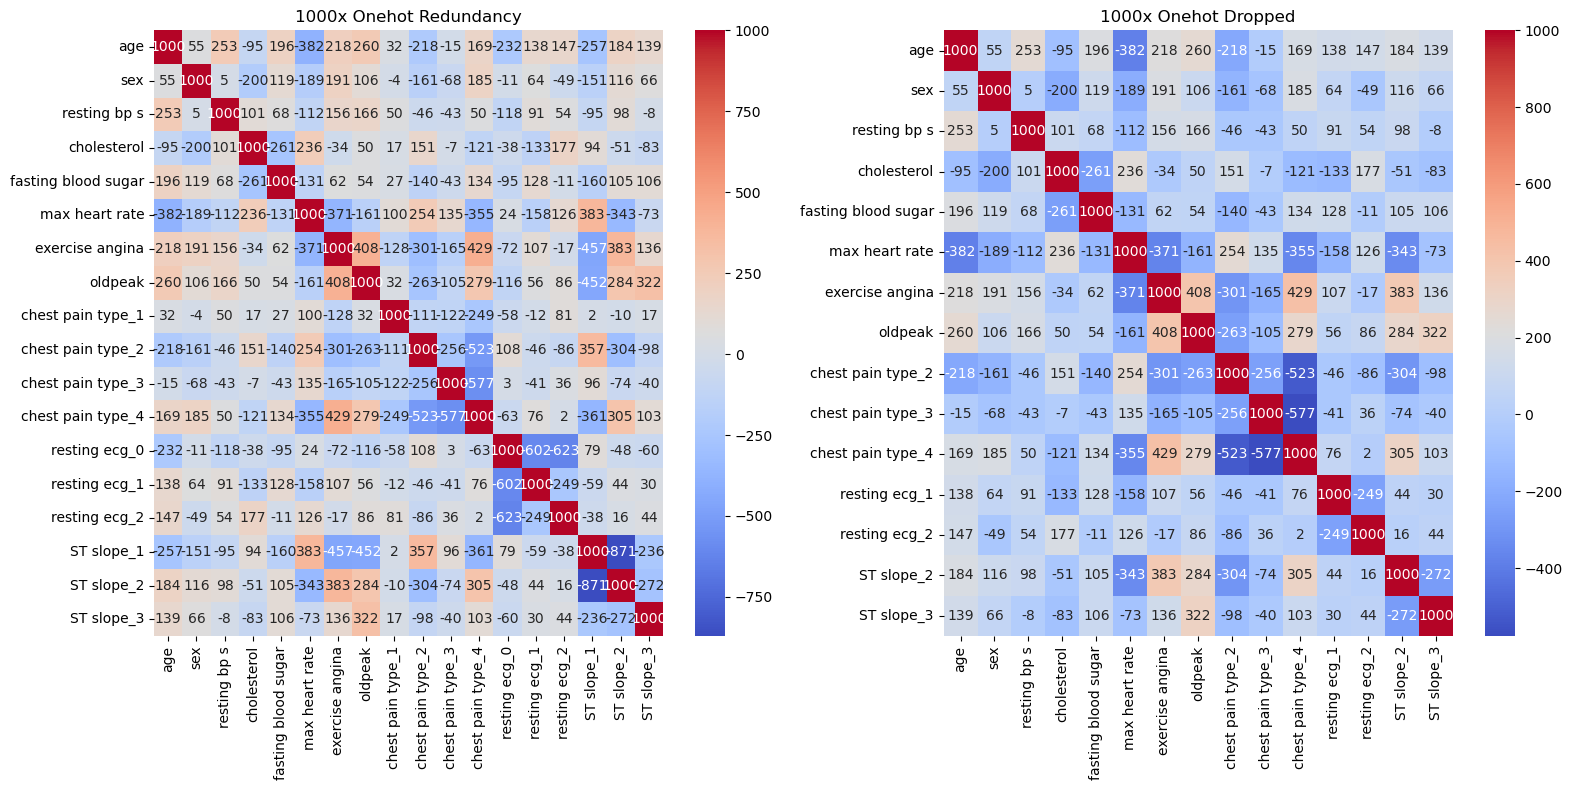

In [38]:
# Function to one-hot encode nominal variables in the dataset
def onehot_encode_nominals(X, nominal_columns, drop_first=False):
    """
    One-hot encodes the nominal columns of the dataset.

    Parameters:
    - X: pd.DataFrame - The dataset with features.
    - nominal_columns: list - List of column names in X to be one-hot encoded.
    - drop_first: bool - Whether to drop the first category to avoid multicollinearity.

    Returns:
    - pd.DataFrame - Dataset with nominal columns one-hot encoded.
    """
    encoder = OneHotEncoder(sparse_output=False, drop='first' if drop_first else None)
    X_nominal = encoder.fit_transform(X[nominal_columns])
    X_nominal = pd.DataFrame(X_nominal, columns=encoder.get_feature_names_out())
    X_numeric = X.drop(nominal_columns, axis=1)
    return pd.concat([X_numeric, X_nominal], axis=1)


# Plot correlation matrices for datasets
def plot_correlation_matrices(df_list, titles, fig_size=(8, 8), resolution=100):
    """
    Plots correlation matrices for a list of DataFrames.

    Parameters:
    - df_list: list - List of DataFrames to plot.
    - titles: list - Titles for each subplot.
    - fig_size: tuple - Figure size (width, height) for the entire plot.
    - resolution: int - Resolution multiplier for heatmap annotations.

    Returns:
    - None - Displays the plots.
    """
    titles = [f'{resolution}x {title}' for title in titles]
    n = len(df_list)
    n_cols = min(n, 3)
    n_rows = (n + n_cols - 1) // n_cols  # Calculate number of rows
    plt.figure(figsize=(n_cols * fig_size[0], n_rows * fig_size[1]))  # Adjust figure size
    for i, df in enumerate(df_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        corr = df.corr()
        sns.heatmap(resolution * corr, annot=True, fmt=".0f", cmap="coolwarm", 
                     xticklabels=df.columns, yticklabels=df.columns, ax=ax)
        ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

# Main data preparation and plotting
target = df['target']  # Target variable
X_pre = df.drop(['target'], axis=1)  # Features excluding target variable
nominal_columns = ['chest pain type', 'resting ecg', 'ST slope']  # Nominal columns to encode

# One-hot encode nominal columns with and without dropping the first category
X_oh = onehot_encode_nominals(X_pre, nominal_columns, drop_first=False)
X_oh_drop = onehot_encode_nominals(X_pre, nominal_columns, drop_first=True)  # Drop first category to avoid redundancy

# List of DataFrames and titles for plotting
dfs = [X_oh, X_oh_drop]
titles = ['Onehot Redundancy', 'Onehot Dropped']

# Plot correlation matrices for both encodings
plot_correlation_matrices(dfs, titles, resolution=1000)



[2024-09-04 02:38:29] Features: 1/18 -- score: 0.8133879781420765
[2024-09-04 02:38:29] Features: 2/18 -- score: 0.8133939177952009
[2024-09-04 02:38:30] Features: 3/18 -- score: 0.8199394155381325
[2024-09-04 02:38:30] Features: 4/18 -- score: 0.8330779282489903
[2024-09-04 02:38:31] Features: 5/18 -- score: 0.8450819672131147
[2024-09-04 02:38:31] Features: 6/18 -- score: 0.8472618199097173
[2024-09-04 02:38:31] Features: 7/18 -- score: 0.8472618199097173
[2024-09-04 02:38:32] Features: 8/18 -- score: 0.8450760275599905
[2024-09-04 02:38:32] Features: 9/18 -- score: 0.8418032786885247
[2024-09-04 02:38:32] Features: 10/18 -- score: 0.8450938465193634
[2024-09-04 02:38:32] Features: 11/18 -- score: 0.8440068899976241
[2024-09-04 02:38:33] Features: 12/18 -- score: 0.8440009503445
[2024-09-04 02:38:33] Features: 13/18 -- score: 0.8440009503445
[2024-09-04 02:38:33] Features: 14/18 -- score: 0.8429080541696365
[2024-09-04 02:38:33] Features: 15/18 -- score: 0.8385305298170586
[2024-09-

Step 1: New Feature Selected: {'ST slope_1'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'exercise angina'}
Step 4: New Feature Selected: {'sex'}
Step 5: New Feature Selected: {'fasting blood sugar'}
Step 6: New Feature Selected: {'ST slope_2'}
Step 7: New Feature Selected: {'ST slope_3'}
Step 8: New Feature Selected: {'resting ecg_2'}
Step 9: New Feature Selected: {'chest pain type_4'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'chest pain type_1'}
Step 12: New Feature Selected: {'chest pain type_2'}
Step 13: New Feature Selected: {'chest pain type_3'}
Step 14: New Feature Selected: {'resting bp s'}
Step 15: New Feature Selected: {'max heart rate'}
Step 16: New Feature Selected: {'resting ecg_0'}
Step 17: New Feature Selected: {'resting ecg_1'}
Step 18: New Feature Selected: {'cholesterol'}



[2024-09-04 02:38:34] Features: 1/15 -- score: 0.7752019482062248
[2024-09-04 02:38:35] Features: 2/15 -- score: 0.8199334758850083
[2024-09-04 02:38:35] Features: 3/15 -- score: 0.8396353052981705
[2024-09-04 02:38:35] Features: 4/15 -- score: 0.8407222618199098
[2024-09-04 02:38:36] Features: 5/15 -- score: 0.8450760275599905
[2024-09-04 02:38:36] Features: 6/15 -- score: 0.8483487764314563
[2024-09-04 02:38:36] Features: 7/15 -- score: 0.8516274649560465
[2024-09-04 02:38:37] Features: 8/15 -- score: 0.8483903540033262
[2024-09-04 02:38:37] Features: 9/15 -- score: 0.8451057258256117
[2024-09-04 02:38:37] Features: 10/15 -- score: 0.8461748633879781
[2024-09-04 02:38:37] Features: 11/15 -- score: 0.8429139938227607
[2024-09-04 02:38:37] Features: 12/15 -- score: 0.8429080541696365
[2024-09-04 02:38:37] Features: 13/15 -- score: 0.8385305298170586
[2024-09-04 02:38:37] Features: 14/15 -- score: 0.834158945117605
[2024-09-04 02:38:37] Features: 15/15 -- score: 0.8287419814682823

Step 1: New Feature Selected: {'ST slope_2'}
Step 2: New Feature Selected: {'exercise angina'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'chest pain type_3'}
Step 5: New Feature Selected: {'chest pain type_2'}
Step 6: New Feature Selected: {'ST slope_3'}
Step 7: New Feature Selected: {'chest pain type_4'}
Step 8: New Feature Selected: {'oldpeak'}
Step 9: New Feature Selected: {'resting ecg_2'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'fasting blood sugar'}
Step 12: New Feature Selected: {'resting bp s'}
Step 13: New Feature Selected: {'max heart rate'}
Step 14: New Feature Selected: {'resting ecg_1'}
Step 15: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8603409360893324


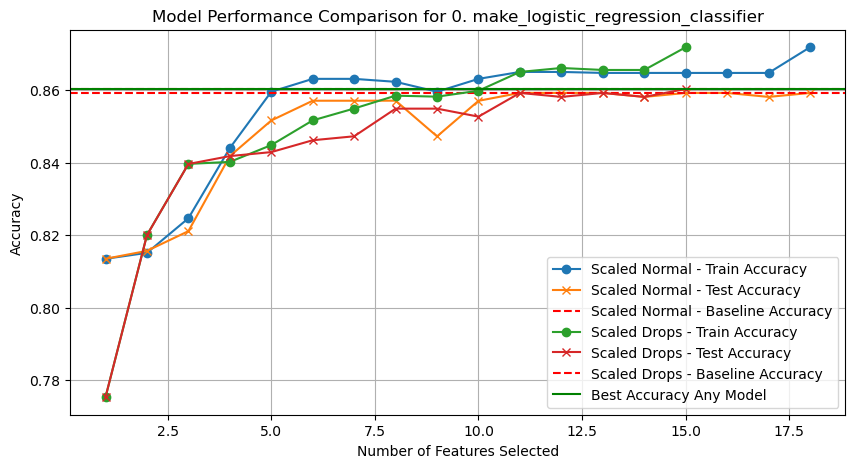

In [39]:
# Normalize the feature sets
X_oh_scaled, _ = normalize_Xtrain(X_oh)  # Normalize features encoded with one-hot encoding
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)  # Normalize features with dropped categories

# Define feature sets for evaluation
Xs = [X_oh_scaled, X_oh_drop_scaled]  # Scaled feature sets
names = ['Scaled Normal', 'Scaled Drops']  # Names corresponding to the scaled feature sets

# Define model types to evaluate (logistic regression only for this task)
model_types = [make_logistic_regression_classifier]  #logistic regression is needed

# Number of features to consider for feature selection
max_features = 4  # Limit the maximum number of features for selection

# Flag indicating whether to use all features
all_features = True  # Use all features if True, otherwise limit to max_features

# Perform feature selection and evaluation
results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(
    Xs,  # List of feature sets
    names,  # Names for each feature set
    target,  # Target variable
    model_types,  # List of model functions (logistic regression here)
    max_features=None if all_features else max_features,  # Use all features if all_features is True
    all_features=all_features,  # Use flag to indicate if all features are used
    num_folds=5,  # Number of folds for cross-validation
    single_split=False  # Use multiple splits for evaluation
)

# Plot the results of the feature selection and model evaluation
plot_results(results, best_overall_test_acc=best_overall_test_acc)


[2024-09-04 02:38:42] Features: 1/18 -- score: 0.8133879781420765
[2024-09-04 02:38:43] Features: 2/18 -- score: 0.8133939177952009
[2024-09-04 02:38:43] Features: 3/18 -- score: 0.8199394155381325
[2024-09-04 02:38:43] Features: 4/18 -- score: 0.8330779282489903
[2024-09-04 02:38:44] Features: 5/18 -- score: 0.8450819672131147
[2024-09-04 02:38:44] Features: 6/18 -- score: 0.8472618199097173
[2024-09-04 02:38:45] Features: 7/18 -- score: 0.8472618199097173
[2024-09-04 02:38:45] Features: 8/18 -- score: 0.8450760275599905
[2024-09-04 02:38:45] Features: 9/18 -- score: 0.8418032786885247
[2024-09-04 02:38:45] Features: 10/18 -- score: 0.8450938465193634
[2024-09-04 02:38:46] Features: 11/18 -- score: 0.8440068899976241
[2024-09-04 02:38:46] Features: 12/18 -- score: 0.8440009503445
[2024-09-04 02:38:46] Features: 13/18 -- score: 0.8440009503445
[2024-09-04 02:38:46] Features: 14/18 -- score: 0.8429080541696365
[2024-09-04 02:38:46] Features: 15/18 -- score: 0.8385305298170586
[2024-09-

Step 1: New Feature Selected: {'ST slope_1'}
Step 2: New Feature Selected: {'oldpeak'}
Step 3: New Feature Selected: {'exercise angina'}
Step 4: New Feature Selected: {'sex'}
Step 5: New Feature Selected: {'fasting blood sugar'}
Step 6: New Feature Selected: {'ST slope_2'}
Step 7: New Feature Selected: {'ST slope_3'}
Step 8: New Feature Selected: {'resting ecg_2'}
Step 9: New Feature Selected: {'chest pain type_4'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'chest pain type_1'}
Step 12: New Feature Selected: {'chest pain type_2'}
Step 13: New Feature Selected: {'chest pain type_3'}
Step 14: New Feature Selected: {'resting bp s'}
Step 15: New Feature Selected: {'max heart rate'}
Step 16: New Feature Selected: {'resting ecg_0'}
Step 17: New Feature Selected: {'resting ecg_1'}
Step 18: New Feature Selected: {'cholesterol'}



[2024-09-04 02:38:48] Features: 1/15 -- score: 0.7752019482062248
[2024-09-04 02:38:48] Features: 2/15 -- score: 0.8199334758850083
[2024-09-04 02:38:48] Features: 3/15 -- score: 0.8396353052981705
[2024-09-04 02:38:49] Features: 4/15 -- score: 0.8407222618199098
[2024-09-04 02:38:49] Features: 5/15 -- score: 0.8450760275599905
[2024-09-04 02:38:49] Features: 6/15 -- score: 0.8483487764314563
[2024-09-04 02:38:50] Features: 7/15 -- score: 0.8516274649560465
[2024-09-04 02:38:50] Features: 8/15 -- score: 0.8483903540033262
[2024-09-04 02:38:50] Features: 9/15 -- score: 0.8451057258256117
[2024-09-04 02:38:50] Features: 10/15 -- score: 0.8461748633879781
[2024-09-04 02:38:50] Features: 11/15 -- score: 0.8429139938227607
[2024-09-04 02:38:50] Features: 12/15 -- score: 0.8429080541696365
[2024-09-04 02:38:50] Features: 13/15 -- score: 0.8385305298170586
[2024-09-04 02:38:51] Features: 14/15 -- score: 0.834158945117605
[2024-09-04 02:38:51] Features: 15/15 -- score: 0.8287419814682823

Step 1: New Feature Selected: {'ST slope_2'}
Step 2: New Feature Selected: {'exercise angina'}
Step 3: New Feature Selected: {'sex'}
Step 4: New Feature Selected: {'chest pain type_3'}
Step 5: New Feature Selected: {'chest pain type_2'}
Step 6: New Feature Selected: {'ST slope_3'}
Step 7: New Feature Selected: {'chest pain type_4'}
Step 8: New Feature Selected: {'oldpeak'}
Step 9: New Feature Selected: {'resting ecg_2'}
Step 10: New Feature Selected: {'age'}
Step 11: New Feature Selected: {'fasting blood sugar'}
Step 12: New Feature Selected: {'resting bp s'}
Step 13: New Feature Selected: {'max heart rate'}
Step 14: New Feature Selected: {'resting ecg_1'}
Step 15: New Feature Selected: {'cholesterol'}
Best Accuracy: 0.8603409360893324


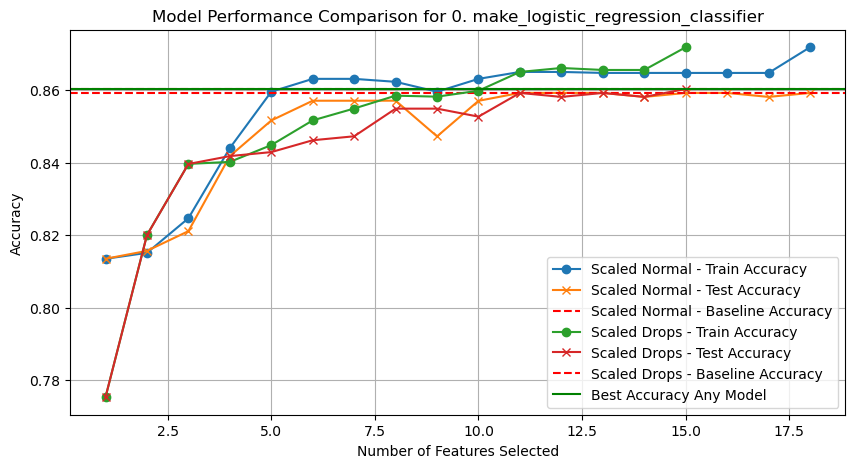

In [40]:
# Define the logistic regression model
def make_logistic_regression_classifier():
    return LogisticRegression(max_iter=1000)

# Define the list of models for evaluation
model_types = [make_logistic_regression_classifier]

# Maximum number of features to consider for selection
max_features = 4
all_features = True

# Evaluate feature selection with logistic regression
results, best_overall_test_acc, dummy_accuracy = evaluate_feature_selection(
    Xs,  # List of feature sets
    names,  # Names for each feature set
    target,  # Target variable
    model_types,  # List of model functions (only logistic regression here)
    max_features,  # Maximum number of features to consider
    all_features=all_features,  # Use all features if True
    num_folds=5,  # Number of folds for cross-validation
    single_split=False,  # Use multiple splits for evaluation
    verbose=False  # Verbosity
)

# Plot the results of the feature selection and model evaluation
plot_results(results, best_overall_test_acc=best_overall_test_acc)


In [41]:
# Normalize the feature sets
X_oh_scaled, _ = normalize_Xtrain(X_oh)
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oh_scaled, target, test_size=0.2, random_state=42)

# Define and train the logistic regression model
model = make_logistic_regression_classifier()  # Logistic Regression model
model.fit(X_train, y_train)

# Optionally, you can evaluate the model on the test set
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.89


In [42]:
# Normalize the feature sets
X_oh_scaled, _ = normalize_Xtrain(X_oh)
X_oh_drop_scaled, _ = normalize_Xtrain(X_oh_drop)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oh_scaled, target, test_size=0.2, random_state=42)

# Define and train the logistic regression model
model = make_logistic_regression_classifier()  # Logistic Regression model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate and print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        74
           1       0.93      0.88      0.91       110

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [43]:
# Train-test split was already performed in the previous code
# X_train, X_test, y_train, y_test = train_test_split(X_oh_scaled, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.1087
R² Score: 0.5479


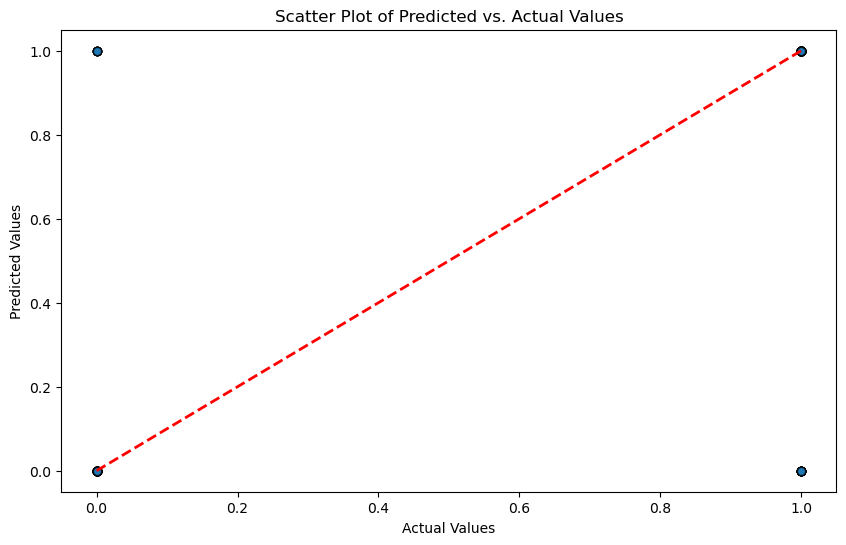

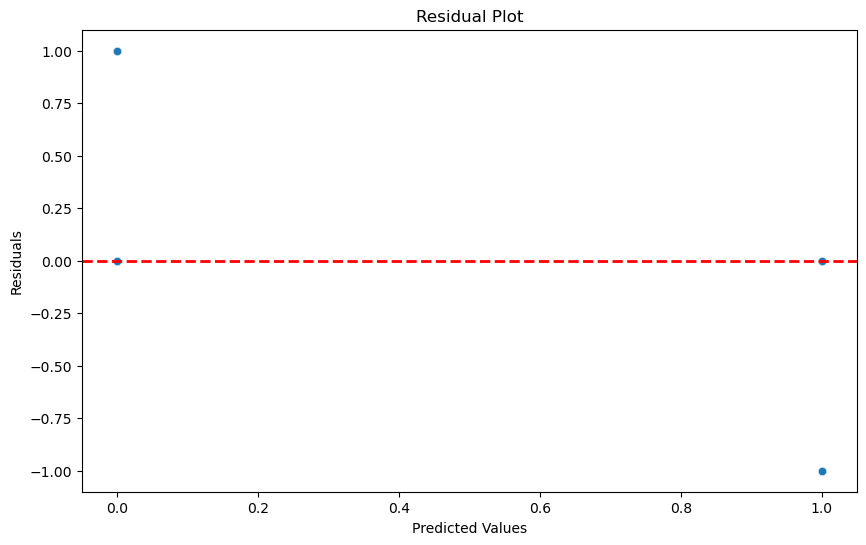

In [44]:
# 1. Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line at 0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [45]:
# Check the column names in the DataFrame
print(df.columns)

# Remove leading/trailing spaces from column names if any
df.columns = df.columns.str.strip()


Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

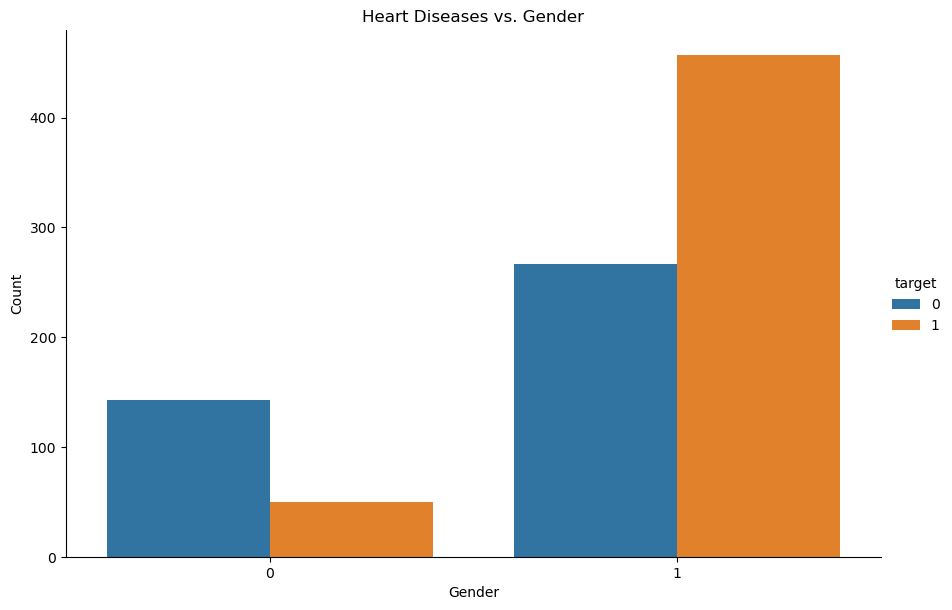

In [46]:
# 1. Heart Diseases vs. Gender Bar Plot
plt.figure(figsize=(10, 6))
sns.catplot(x='sex', hue='target', kind='count', data=df, height=6, aspect=1.5)
plt.title('Heart Diseases vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


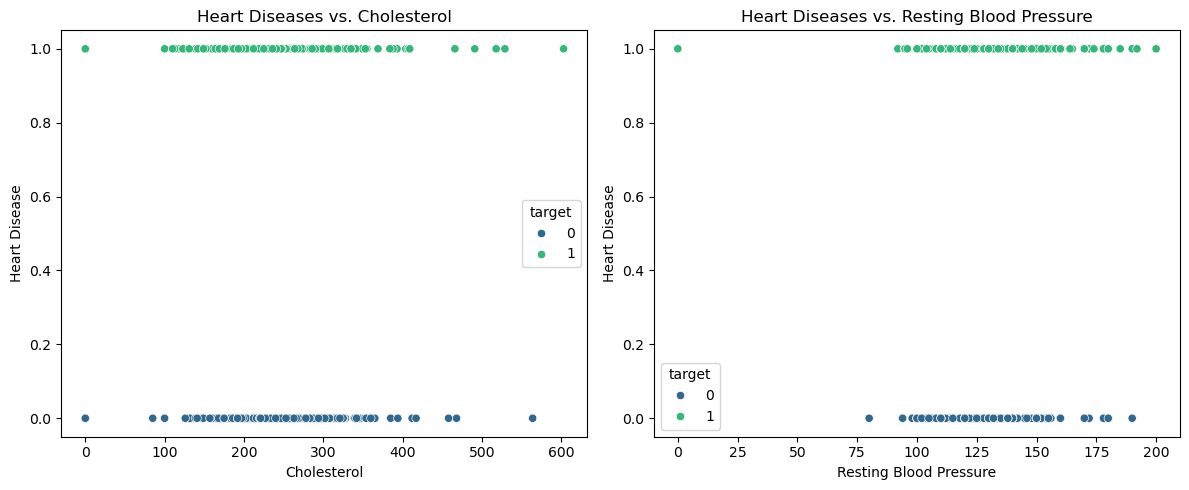

In [47]:
# 3a. Heart Diseases vs. Cholesterol Scatter Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='cholesterol', y='target', data=df, hue='target', palette='viridis')
plt.title('Heart Diseases vs. Cholesterol')
plt.xlabel('Cholesterol')
plt.ylabel('Heart Disease')

# 3b. Heart Diseases vs. Resting Blood Pressure Scatter Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x='resting bp s', y='target', data=df, hue='target', palette='viridis')
plt.title('Heart Diseases vs. Resting Blood Pressure')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Heart Disease')

plt.tight_layout()
plt.show()


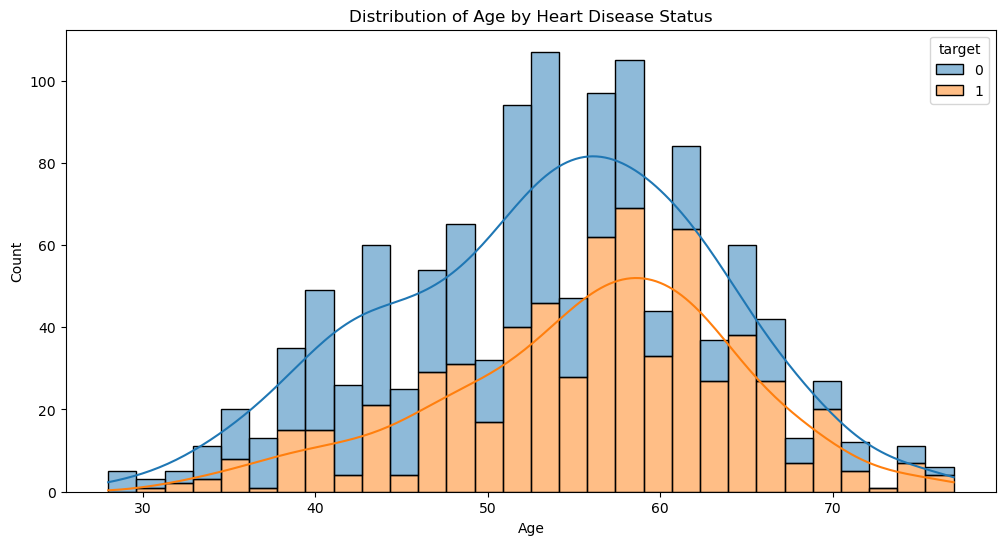

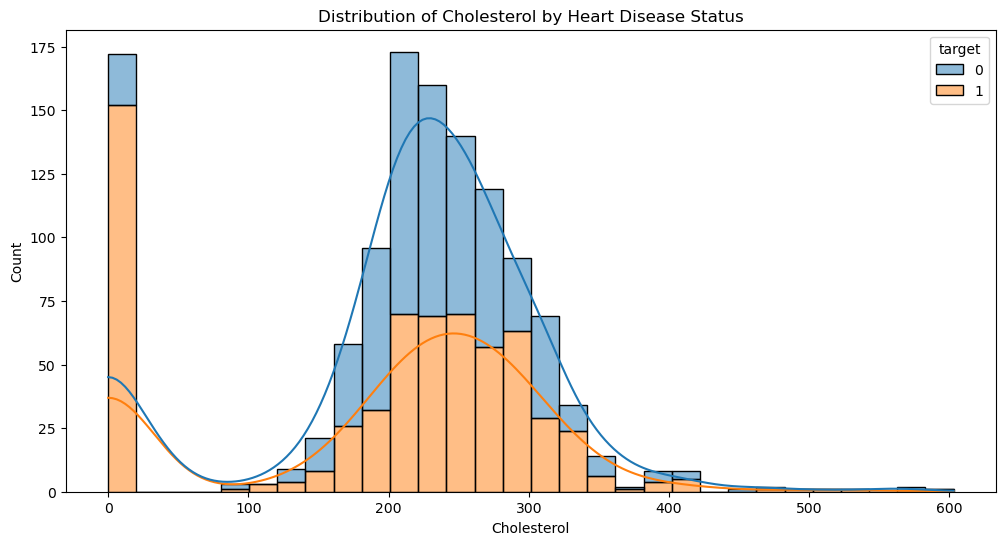

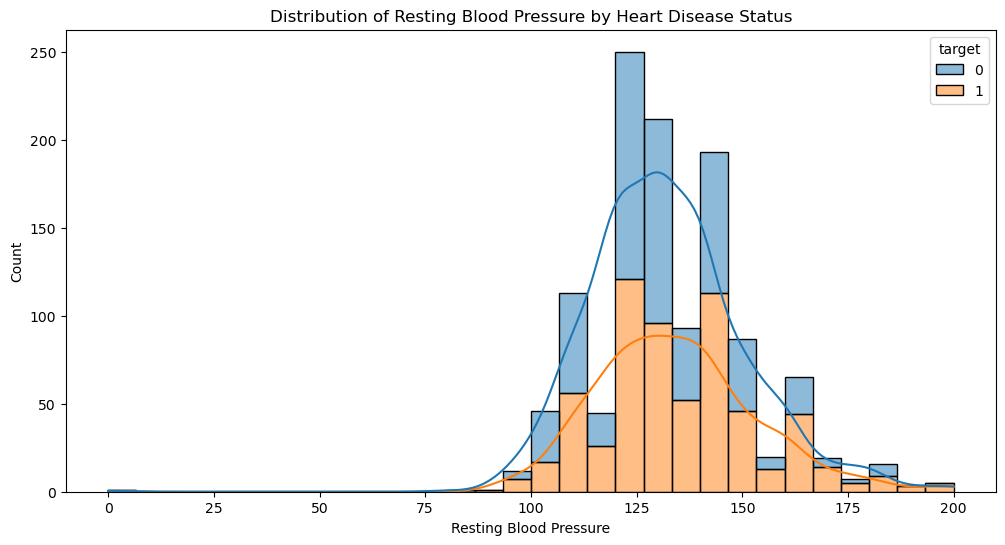

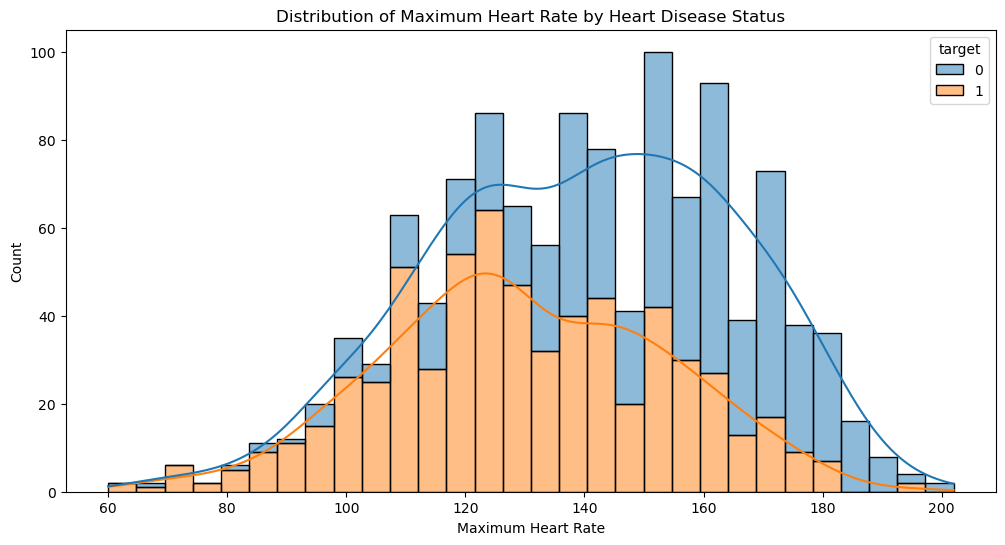

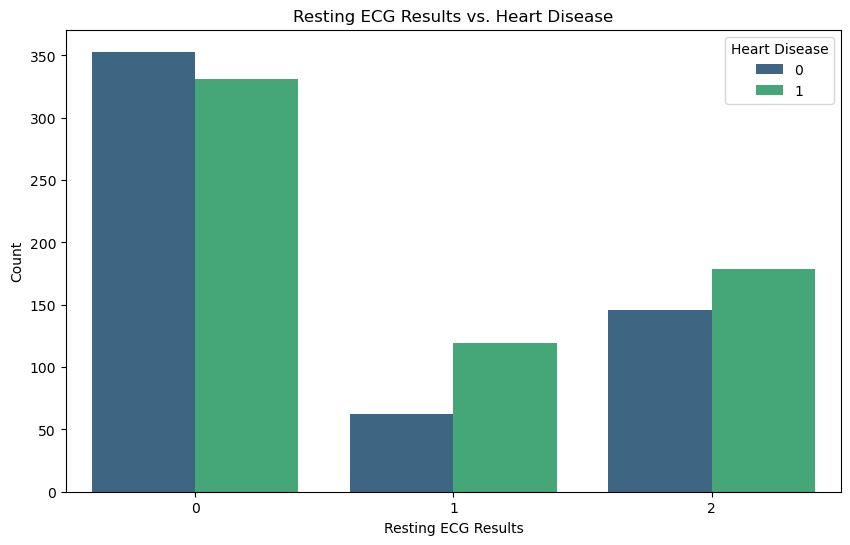

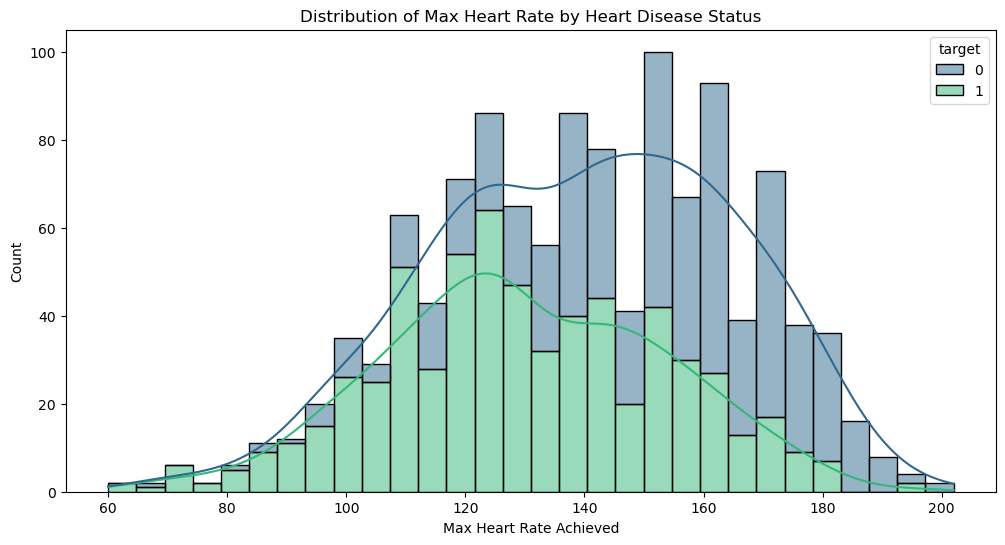

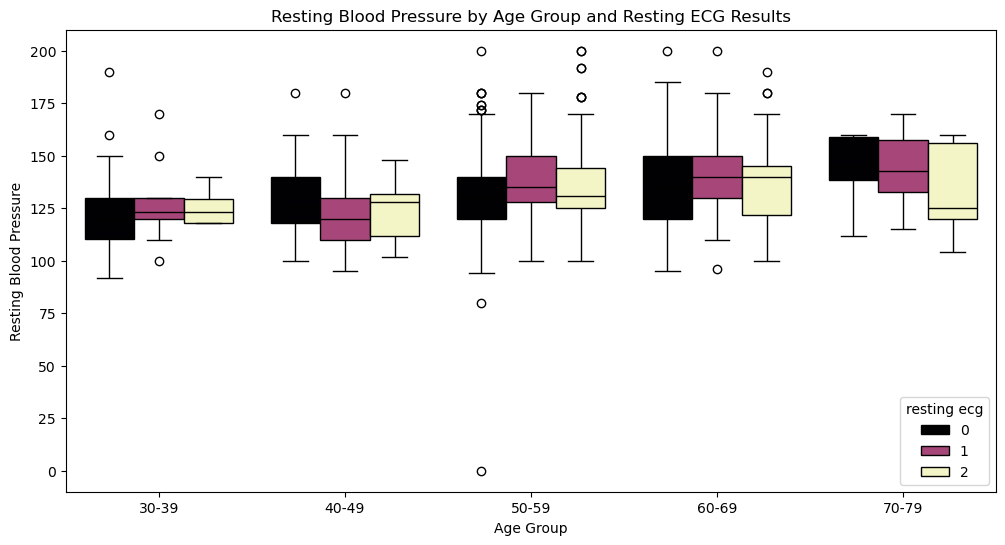

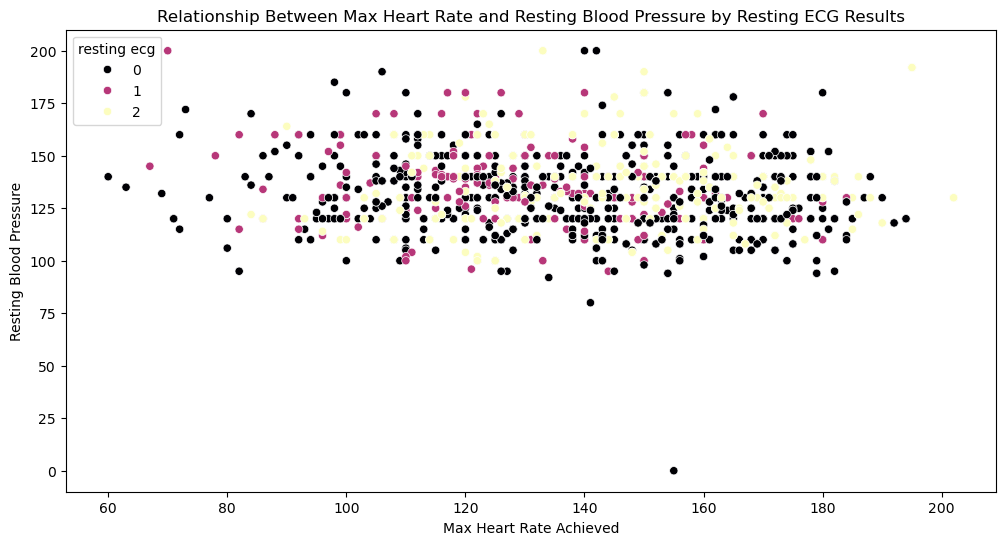

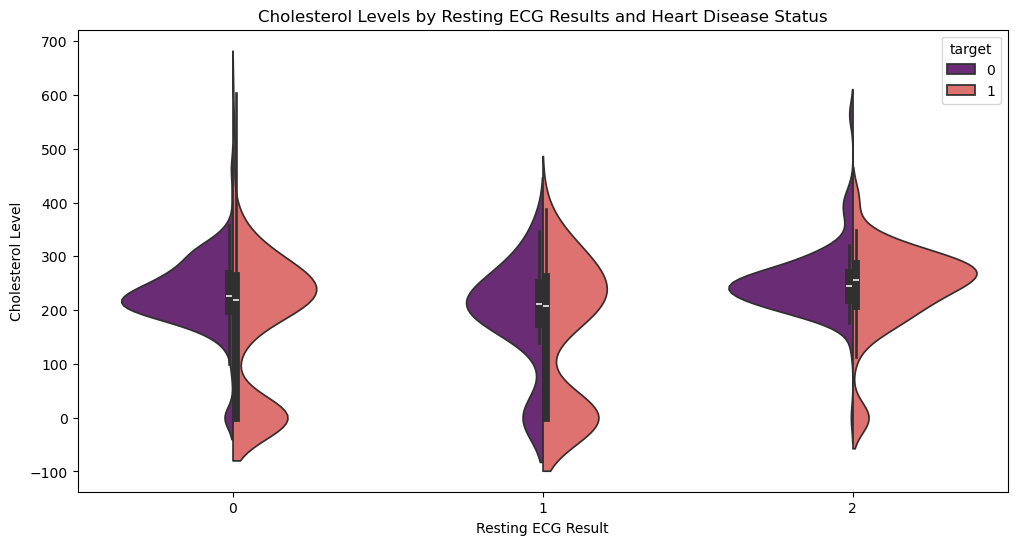

In [66]:
# Distribution of Age
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
# Plot histogram of age distribution, stacked by heart disease status, with KDE overlay
sns.histplot(data=df, x='age', hue='target', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Age by Heart Disease Status')  # Title of the plot
plt.xlabel('Age')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()  # Display the plot

# Distribution of Cholesterol
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
# Plot histogram of cholesterol distribution, stacked by heart disease status, with KDE overlay
sns.histplot(data=df, x='cholesterol', hue='target', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Cholesterol by Heart Disease Status')  # Title of the plot
plt.xlabel('Cholesterol')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()  # Display the plot

# Distribution of Resting Blood Pressure
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
# Plot histogram of resting blood pressure distribution, stacked by heart disease status, with KDE overlay
sns.histplot(data=df, x='resting bp s', hue='target', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Resting Blood Pressure by Heart Disease Status')  # Title of the plot
plt.xlabel('Resting Blood Pressure')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()  # Display the plot

#Distribution of Maximum Heart Rate by Heart Disease Status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='max heart rate', hue='target', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Maximum Heart Rate by Heart Disease Status')
plt.xlabel('Maximum Heart Rate')
plt.ylabel('Count')
plt.show()

# Resting ECG Results vs. Heart Disease
plt.figure(figsize=(10, 6))
sns.countplot(x='resting ecg', hue='target', data=df, palette='viridis')
plt.title('Resting ECG Results vs. Heart Disease')
plt.xlabel('Resting ECG Results')
plt.ylabel('Count')
plt.legend(title='Heart Disease')
plt.show()

#Distribution of Max Heart Rate Achieved
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='max heart rate', hue='target', multiple='stack', bins=30, kde=True, palette='viridis')
plt.title('Distribution of Max Heart Rate by Heart Disease Status')
plt.xlabel('Max Heart Rate Achieved')
plt.ylabel('Count')
plt.show()

#Resting ECG Results Across Different Age Groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='resting bp s', hue='resting ecg', data=df, palette='magma')
plt.title('Resting Blood Pressure by Age Group and Resting ECG Results')
plt.xlabel('Age Group')
plt.ylabel('Resting Blood Pressure')
plt.show()

#Relationship Between Resting ECG Results and Max Heart Rate
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='max heart rate', y='resting bp s', hue='resting ecg', palette='magma')
plt.title('Relationship Between Max Heart Rate and Resting Blood Pressure by Resting ECG Results')
plt.xlabel('Max Heart Rate Achieved')
plt.ylabel('Resting Blood Pressure')
plt.show()

# Resting ECG Results and Cholesterol Levels
plt.figure(figsize=(12, 6))
sns.violinplot(x='resting ecg', y='cholesterol', hue='target', data=df, split=True, palette='magma')
plt.title('Cholesterol Levels by Resting ECG Results and Heart Disease Status')
plt.xlabel('Resting ECG Result')
plt.ylabel('Cholesterol Level')
plt.show()

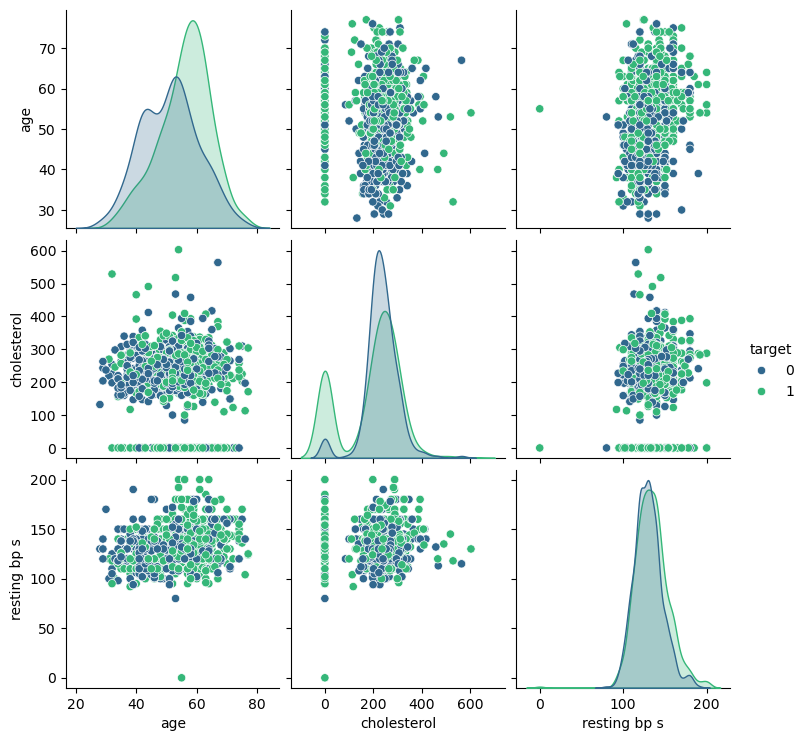

In [67]:
# pair plot to visualize pairwise relationships between selected features and heart disease status
sns.pairplot(df, 
             vars=['age', 'cholesterol', 'resting bp s'],  # Select the features/variables to include in the pair plot
             hue='target',  # Color the points based on the 'target' column (heart disease status)
             palette='viridis')  # Use the 'viridis' color palette for better visualization
plt.show()  # Display the pair plot
